# Final project for "How to win a data science competition" Coursera course

## Importing Libraries

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict


STEPS = 31
PERIODS = 4

## Loading Data

### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [3]:
trainData = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'])

### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [4]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [5]:
trainData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'date_block_num'}>],
       [<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>]], dtype=object)

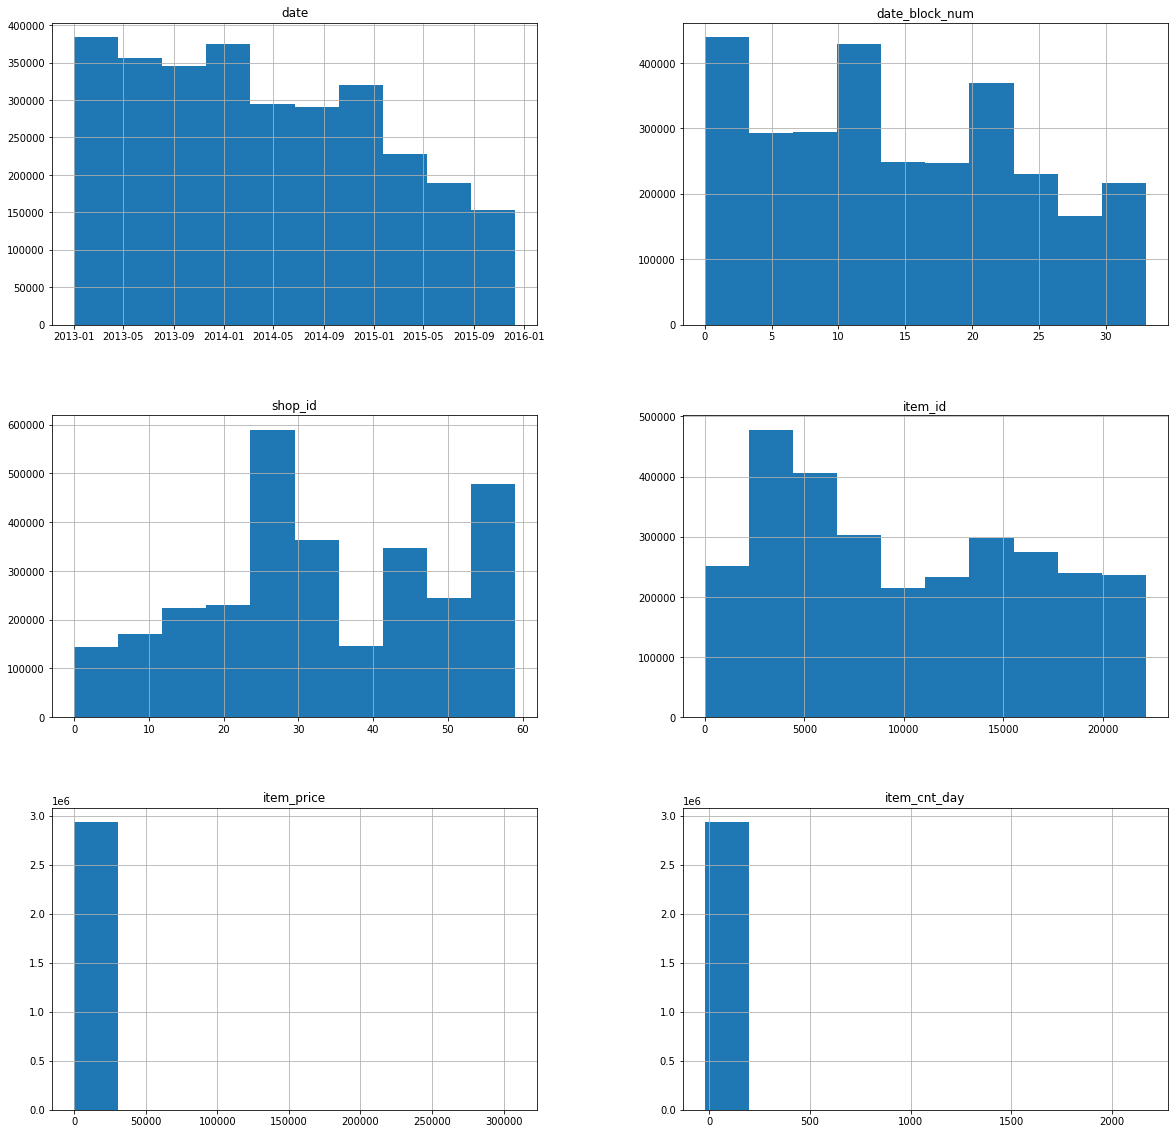

In [6]:
trainData.hist(figsize=(20, 20))

## Data Preprocessing

In [7]:
trainData = trainData[(trainData['item_price'] > 0) & (trainData['item_price'] < 10000)]
trainData = trainData[(trainData['item_cnt_day']>0) & (trainData['item_cnt_day'] < 1000)]

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

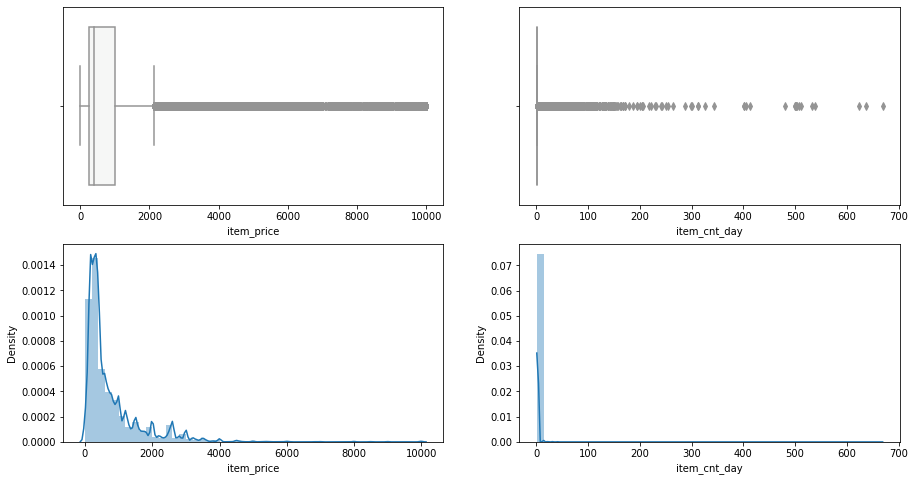

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(trainData['item_price'], palette='PRGn', ax = ax[0, 0])
sns.distplot(trainData['item_price'], ax = ax[1, 0])
sns.boxplot(trainData['item_cnt_day'], palette='PRGn', ax = ax[0, 1])
sns.distplot(trainData['item_cnt_day'], ax = ax[1, 1])

## Time Series Analysis

### Rolling mean and standard deviation graphs

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, period = 12, dft=False):
    movingAVG = df.rolling(window=period).mean()
    movingSTD = df.rolling(window=period).std()
    #plot
    plt.figure(figsize=(15, 10))
    df.plot(label='Original', alpha=0.3)
    mean = plt.plot(movingAVG, label='Rolling Mean')
    std = plt.plot(movingSTD, label='Rolling  Standard Deviation', alpha=0.5)
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    if dft:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(df, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['\nCritical Value (%s)' % key] = value
        print(dfoutput)

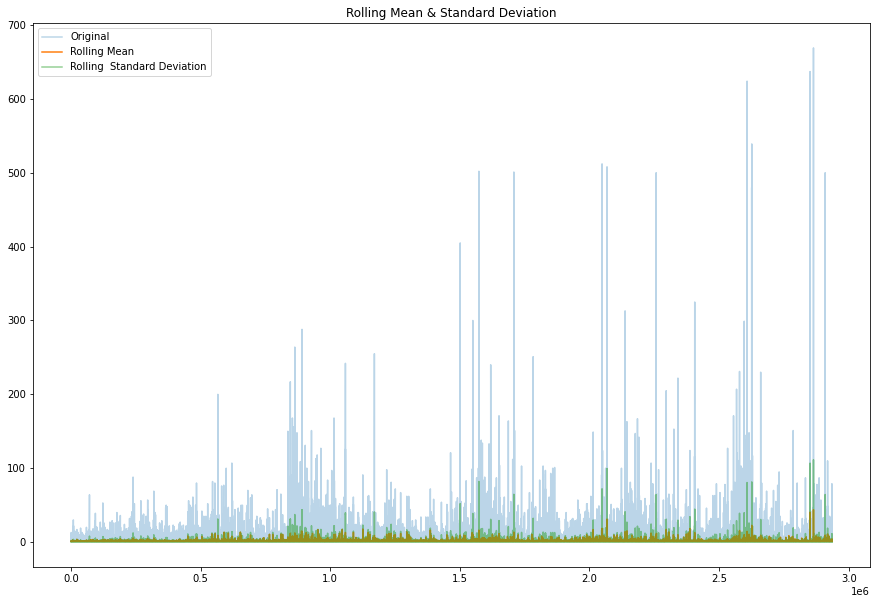

In [10]:
test_stationarity(trainData['item_cnt_day'], period = 60)

### Per month

In [11]:
trainData['Month'] = trainData['date'].dt.to_period('M')
trainData

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
0,2013-02-01,0,59,22154,999.00,1.0,2013-02
1,2013-03-01,0,25,2552,899.00,1.0,2013-03
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
5,2013-10-01,0,25,2564,349.00,1.0,2013-10
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10
2935845,2015-09-10,33,25,7460,299.00,1.0,2015-09
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10


<AxesSubplot:xlabel='Month'>

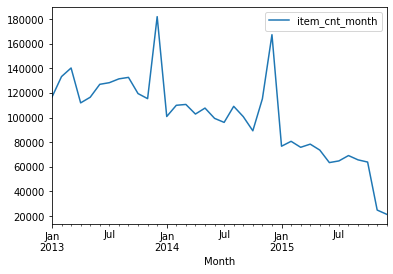

In [12]:
trainDataPerMonth = trainData.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
trainDataPerMonth.reset_index(inplace=True)
trainDataPerMonth = trainDataPerMonth.set_index('Month')
trainDataPerMonth.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
trainDataPerMonth.plot()

### Decomposition Type and data transformation

In [13]:
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
def tsdisplay(y, figsize = (15, 10), title = "", lags = 12):
    tmp_data = y
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

In [14]:
#Import the required modules for model estimation:
import statsmodels.tsa as smt
def decomposition(df):
    log_passengers = np.log(df)
    decomposition_1  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", period = 12, two_sided = True)
    fig, ax = plt.subplots(4, 1, figsize=(15, 8))
    # Plot the series
    decomposition_1.observed.plot(ax = ax[0])
    decomposition_1.trend.plot(ax = ax[1])
    decomposition_1.seasonal.plot(ax = ax[2])
    decomposition_1.resid.plot(ax = ax[3])
    # Add the labels to the Y-axis
    ax[0].set_ylabel('Observed')
    ax[1].set_ylabel('Trend')
    ax[2].set_ylabel('Seasonal')
    ax[3].set_ylabel('Residual')
    # Fix layout
    plt.tight_layout()
    plt.show()

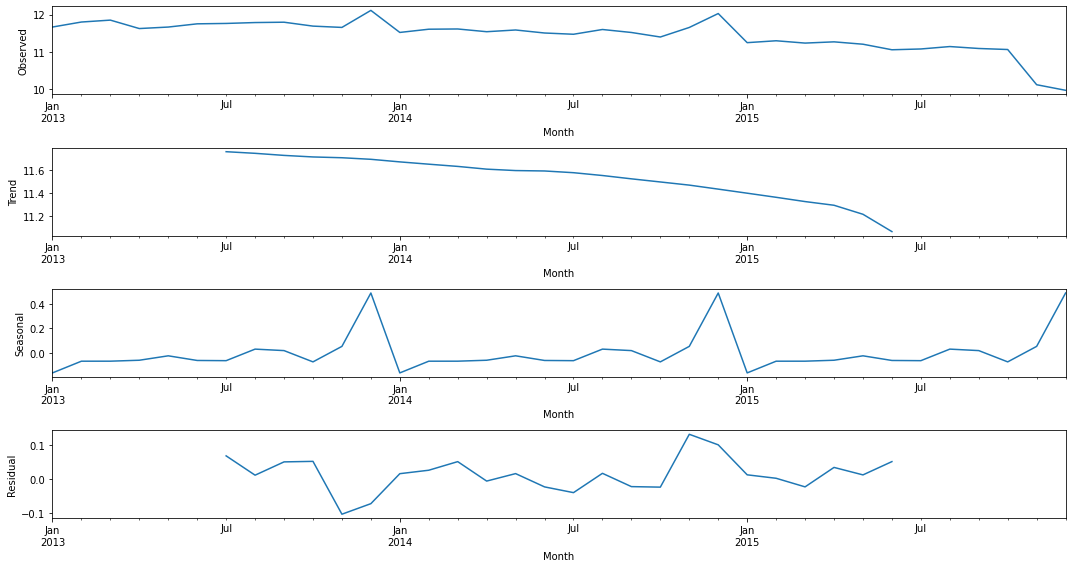

In [15]:
decomposition(trainDataPerMonth)

 #### Checks for Stationarity of the time serie

Results of Dickey-Fuller Test:
Test Statistic                 -0.117068
p-value                         0.947712
#Lags Used                      2.000000
Number of Observations Used    33.000000
\nCritical Value (1%)          -3.646135
\nCritical Value (5%)          -2.954127
\nCritical Value (10%)         -2.615968
dtype: float64


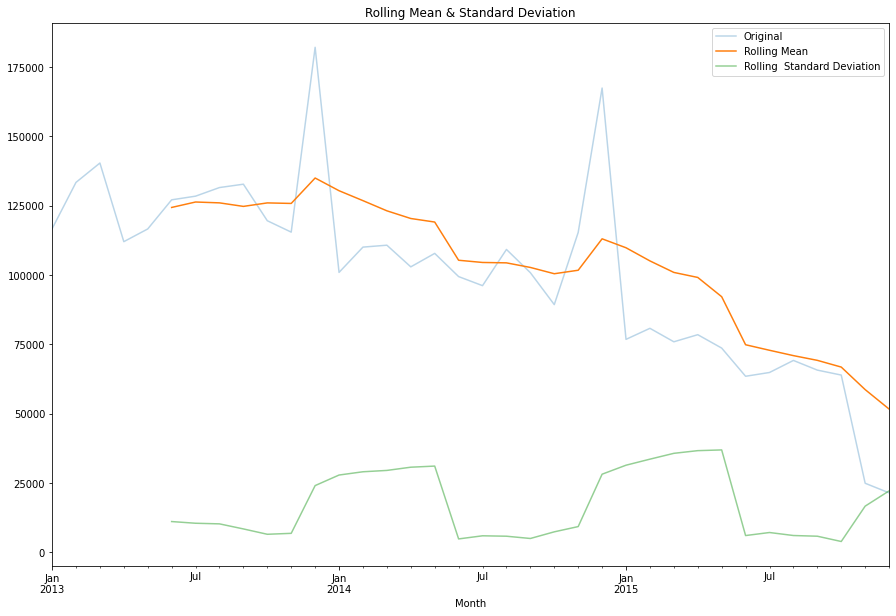

In [16]:
test_stationarity(trainDataPerMonth['item_cnt_month'], 6, True)

The p-value is greater than the critical value of 0.05. The series is not stationary

## Forecasting

### Train Test Split

<AxesSubplot:xlabel='Month'>

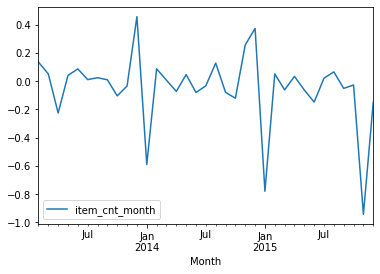

In [17]:
log_passengers = np.log(trainDataPerMonth)
trainDataPerMonthShift = log_passengers - log_passengers.shift()
trainDataPerMonthShift.dropna(inplace=True)
trainDataPerMonthShift.plot()

Train dates : 2013-02 --- 2015-08  (n=31)
Test dates  : 2015-09 --- 2015-12  (n=4)


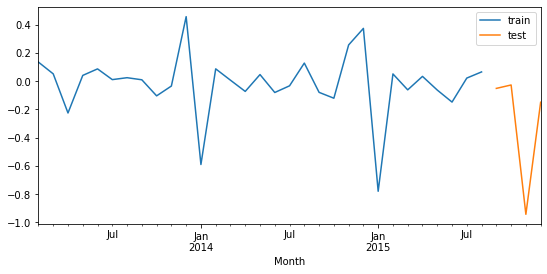

In [18]:
train = trainDataPerMonthShift[:STEPS]
test = trainDataPerMonthShift[STEPS:]

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax = plt.subplots(figsize=(9, 4))
train['item_cnt_month'].plot(ax=ax, label='train')
test['item_cnt_month'].plot(ax=ax, label='test')
ax.legend()

#### ARIMA

Text(0.5, 1.0, 'ARIMA model')

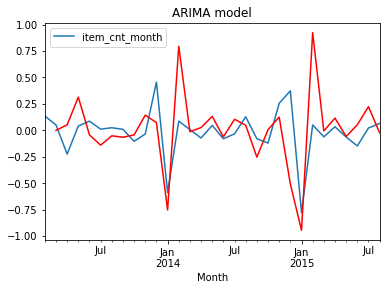

In [19]:
trainShift1 = train - train.shift(1)
trainShift1 = trainShift1.dropna()
model = sm.tsa.arima.ARIMA(trainShift1, order=(0,0,2))
results_ARIMA = model.fit()
train.plot()
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA model')

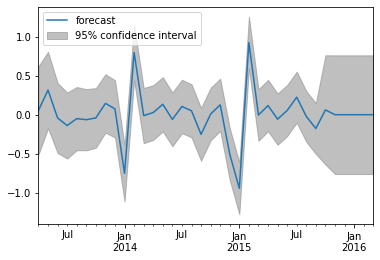

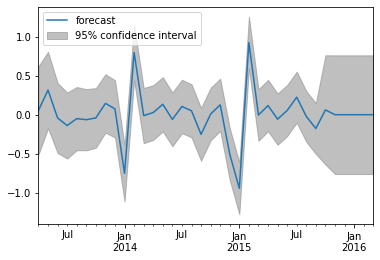

In [20]:
plot_predict(results_ARIMA, 1,36)

In [21]:
ARIMAForecast = results_ARIMA.forecast(steps=PERIODS)

In [22]:

from sklearn.metrics import mean_squared_error
mean_squared_error(ARIMAForecast,test['item_cnt_month'])


0.2323502622809216

In [23]:
pred = pd.Series(ARIMAForecast, index = test.index)

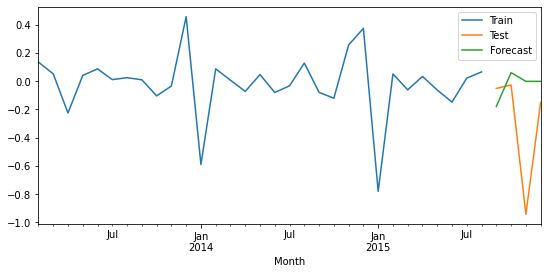

In [24]:
fig, ax = plt.subplots(figsize=(9, 4))
train['item_cnt_month'].plot(ax=ax, label='Train')
test['item_cnt_month'].plot(ax=ax, label='Test')
pred.plot(label='Forecast')
ax.legend()

#### Auto ARIMA + SHIFT

Results of Dickey-Fuller Test:
Test Statistic                -7.001481e+00
p-value                        7.302789e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
\nCritical Value (1%)         -3.646135e+00
\nCritical Value (5%)         -2.954127e+00
\nCritical Value (10%)        -2.615968e+00
dtype: float64


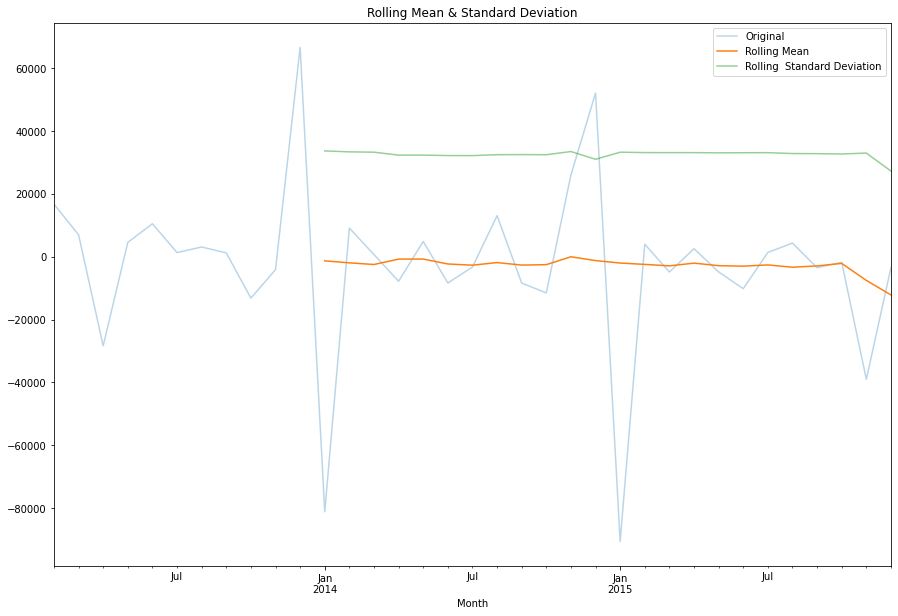

In [25]:
trainDataPerMonthDiff = trainDataPerMonth - trainDataPerMonth.shift()
trainDataPerMonthDiff = trainDataPerMonthDiff.dropna()
test_stationarity(trainDataPerMonthDiff['item_cnt_month'], 12, True)

In [26]:
modelWithShift = auto_arima(
    y=trainDataPerMonthDiff[:STEPS],
    seasonal=True,
    start_p = 0, max_p =5,
    start_q = 0, max_q =5,
    d=None,
    start_P = 1, max_P =5,
    start_Q = 1, max_Q =5,
    D=1,
    m=12,
    test = "adf",
    trace = True, 
    information_criterion = 'aic', 
    suppress_warnings = True, 
    stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=403.484, Time=0.17 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=402.974, Time=0.22 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=399.885, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=390.680, Time=0.10 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=389.684, Time=0.04 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=390.715, Time=0.10 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=392.592, Time=0.23 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=389.765, Time=0.05 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=398.940, Time=0.01 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=384.700, Time=0.10 sec
 ARIMA(1,2,2)(1,1,0)[12]             : AIC=386.344, Time=0.31 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=386.319, Time=0.43 sec
 ARIMA(1,2,2)(1,1,1)[12]             : AIC=388.216, Time=0.82 sec
 ARIMA(2,2,2)(0,1,0)[12]             

In [27]:
modelWithShift.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   31
Model:             SARIMAX(1, 2, 2)x(0, 1, [], 12)   Log Likelihood                -188.350
Date:                             Thu, 04 Aug 2022   AIC                            384.700
Time:                                     15:29:16   BIC                            388.033
Sample:                                          0   HQIC                           385.032
                                              - 31                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0058      0.616      0.009      0.992      -1.201       1.213
ma.L1         -1.8717      0.639     -2.928      0.003      -3.125      -0.619
ma.L2          0.9040      0.635      1.423      0.155      -0.341       2.149
sigma2       3.64e+08   2.76e-09   1.32e+17      0.000    3.64e+08    3.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.60   Prob(JB):                         0.35
Heteroskedasticity (H):               0.26   Skew:                             0.86
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.59e+32. Standard errors may be unstable.
"""

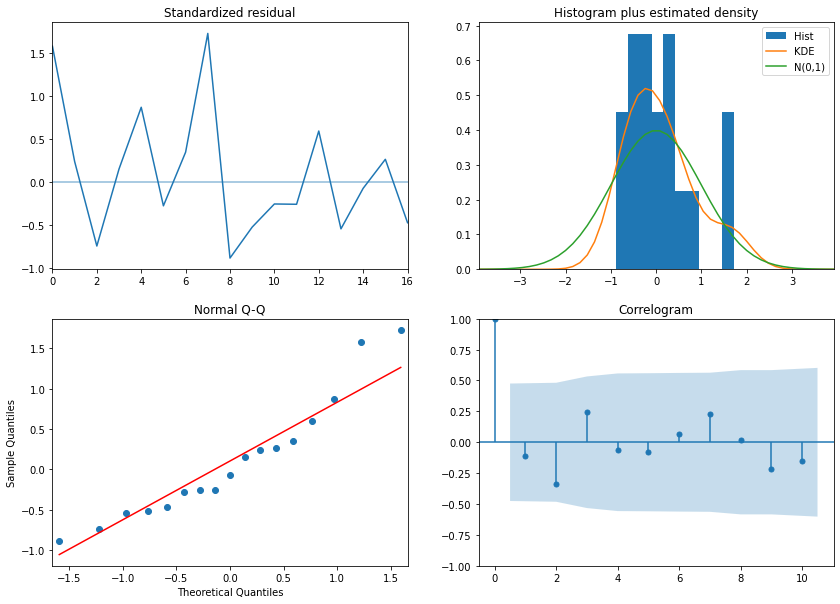

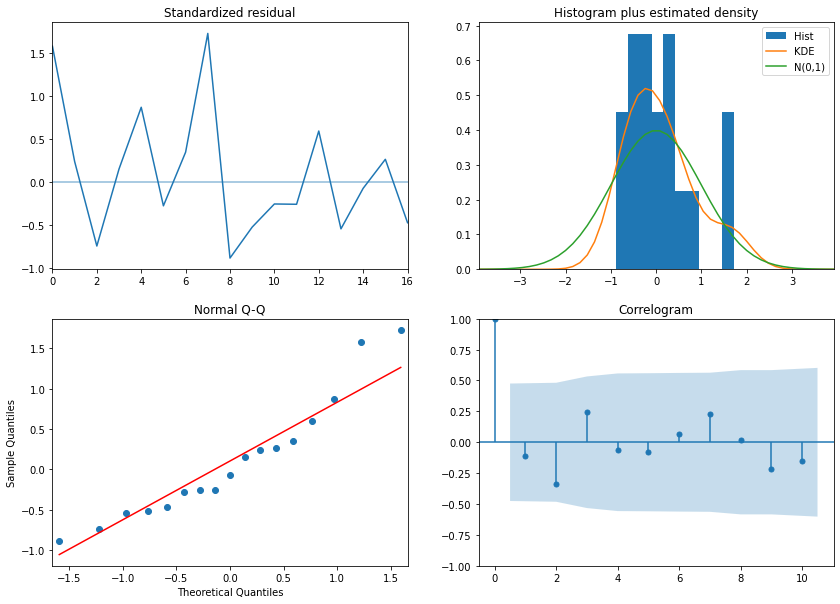

In [28]:
modelWithShift.plot_diagnostics(figsize=(14,10))

In [29]:
prediction, confint = modelWithShift.predict(n_periods=PERIODS, return_conf_int=True)
confint_df = pd.DataFrame(confint)
prediction

array([ -9138.5815036 , -12301.24570607,  25148.50662442,  51126.98678674])

In [30]:
period_index = pd.period_range(
    start = trainDataPerMonthDiff[STEPS:].index[0],
    periods = PERIODS,
    freq='M'
)
predicted_df = pd.DataFrame({'value':prediction}, index=period_index)

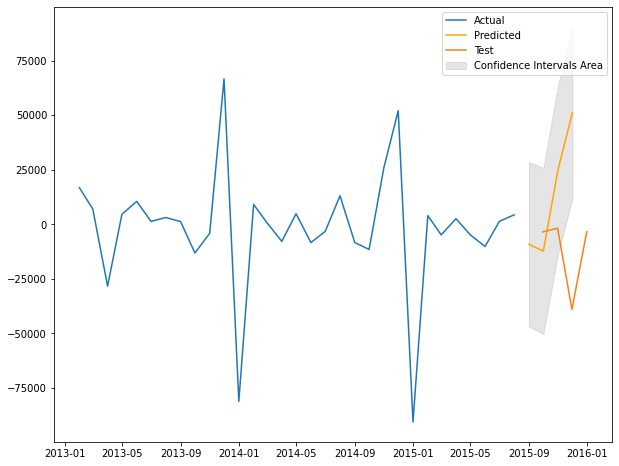

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(trainDataPerMonthDiff[:STEPS].to_timestamp(), label='Actual')
plt.plot(predicted_df.to_timestamp(), color='orange', label='Predicted')
plt.plot(trainDataPerMonthDiff[STEPS:], label='Test')
plt.fill_between(period_index.to_timestamp(), confint_df[0], confint_df[1], color='grey', alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

#### Auto ARIMA

In [32]:
model=auto_arima(trainDataPerMonth[:STEPS],
                 start_p = 0, start_q = 0, 
                 d=1,
                 D=1, 
                 m = 12, 
                 seasonal = True, 
                 test = "adf",  
                 trace = True, 
                 alpha = 0.05, 
                 information_criterion = 'aic', 
                 suppress_warnings = True, 
                 stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=391.217, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=394.977, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=394.981, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=393.152, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=393.184, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=392.978, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=392.981, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=394.981, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=393.059, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.729 seconds


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -194.609
Date:                            Thu, 04 Aug 2022   AIC                            391.217
Time:                                    15:29:19   BIC                            392.108
Sample:                                         0   HQIC                           391.340
                                             - 31                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.321e+08   3.76e+07      3.510      0.000    5.83e+07    2.06e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.38   Prob(JB):                         0.18
Heteroskedasticity (H):               0.32   Skew:                             1.02
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

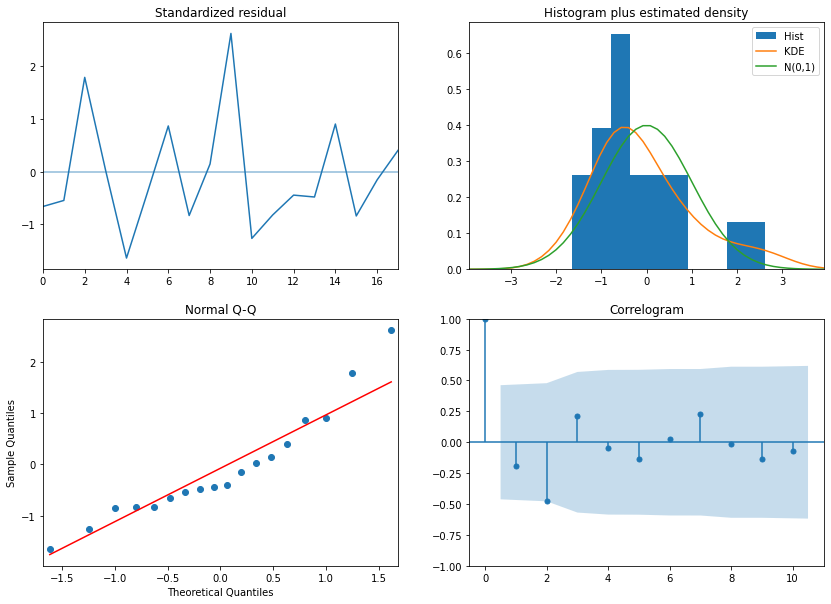

In [34]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [35]:
prediction, confint = model.predict(n_periods = PERIODS, return_conf_int = True)
period_index = pd.period_range(start = trainDataPerMonthDiff[STEPS:].index[0], periods = PERIODS, freq='M')
forecast = pd.DataFrame({'Predicted item_cnt_month': prediction.round(2)}, index = period_index)
forecast.head()

,Predicted item_cnt_month
2015-09,77909.0
2015-10,69534.0
2015-11,58024.0
2015-12,84038.0


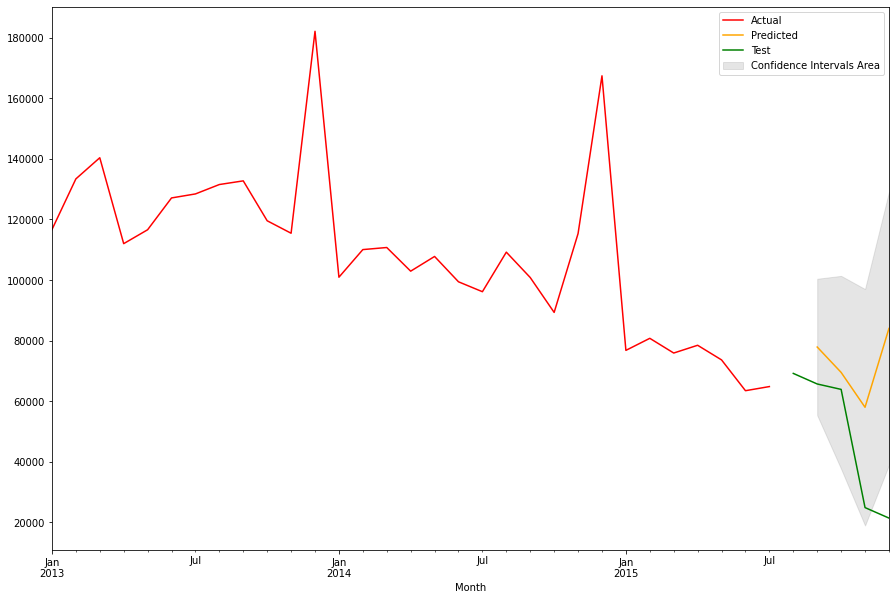

In [36]:
confint_df = pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 10))
trainDataPerMonth['item_cnt_month'][:STEPS].plot(color='red', label='Actual')
prediction_series.plot(color='orange', label='Predicted')
trainDataPerMonth['item_cnt_month'][STEPS:].plot(color='green', label='Test')
plt.fill_between(prediction_series.index.to_timestamp(), confint_df[0], confint_df[1], color='grey', alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

In [37]:
trainDF = trainData.groupby(['shop_id', 'item_id'])['date', 'item_cnt_day'].agg({'item_cnt_day':'sum'})
trainDF = trainDF.reset_index()
trainDF.head()

,shop_id,item_id,item_cnt_day
0,0,30,31.0
1,0,31,11.0
2,0,32,16.0
3,0,33,6.0
4,0,35,15.0


## Submission

### Loading test data

In [38]:
testData = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
testData.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [39]:
testData['item_cnt_month'] = (prediction[0].round(2)*len(testData)/len(testData))/len(testData)
submission  = testData.drop(['shop_id', 'item_id'], axis = 1)
submission.head()

,ID,item_cnt_month
0,0,0.363721
1,1,0.363721
2,2,0.363721
3,3,0.363721
4,4,0.363721


In [40]:
submission.to_csv('submission.csv', index = False)